2022-03-14 Ludovico Massaccesi

# Exercises
Note on the PRNG: `numpy` uses PCG-64 by default, which has a period of $2^{128}$. One can also use (among other things) the slower MT19937, which has a period of $2^{19937}−1$.

In [38]:
%matplotlib inline
%load_ext Cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.special import gamma, binom
from scipy.optimize import curve_fit

The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


## Sample and display distributions

### Using the acceptance-rejection method
The PDF (normalized so that the maximum is 1) is
$$p(x,y)=\frac{xy^2+x}{2}\quad x,y\in[0,1]\times[0,1]$$

Efficiency = 33.33%


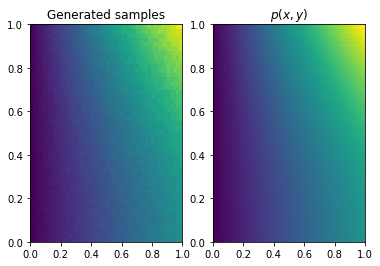

CPU times: user 1.29 s, sys: 51.6 ms, total: 1.34 s
Wall time: 1.34 s


In [2]:
%%time
SZ = int(1e7)
x = np.random.uniform(0, 1, size=SZ)
y = np.random.uniform(0, 1, size=SZ)
p = (x * y**2 + x) / 2
r = np.random.uniform(0, 1, size=SZ)
x = x[r < p]
y = y[r < p]
print(f"Efficiency = {len(x)/SZ:.2%}")

plt.subplot(121)
plt.hist2d(x, y, bins=[50,50], range=[[0,1],[0,1]])
plt.title("Generated samples")

plt.subplot(122)
xe = np.linspace(0, 1, 51, endpoint=True)
ye = np.linspace(0, 1, 51, endpoint=True)
xem, yem = np.meshgrid(xe[:-1], ye[:-1])
pem = (xem * yem**2 + xem) / 2
plt.pcolormesh(xe, ye, pem)
plt.title("$p(x,y)$")

plt.show()

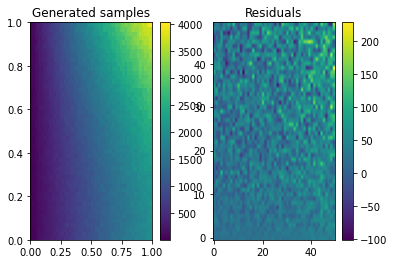

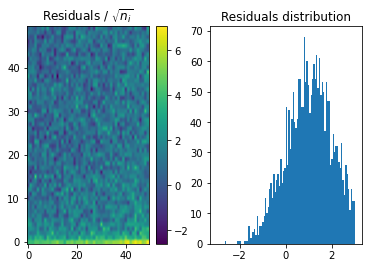

In [3]:
plt.subplot(121)
hist, _, _, _ = plt.hist2d(x, y, bins=[50,50], range=[[0,1],[0,1]])
plt.title("Generated samples")
plt.colorbar()

plt.subplot(122)
# The p(x,y) integral is 1/3; the number of bins is 50²
#plt.matshow(hist)
#plt.matshow(3*len(x)*pem/(50**2))
plt.imshow(hist - 3*len(x)*pem.T/(50**2), origin='lower', aspect='auto')
plt.colorbar()
plt.title("Residuals")

plt.show()

plt.subplot(121)
plt.imshow((hist - 3*len(x)*pem.T/(50**2)) / np.sqrt(hist),
           origin='lower', aspect='auto')
plt.colorbar()
plt.title("Residuals / $\sqrt{n_i}$")

plt.subplot(122)
plt.hist(((hist - 3*len(x)*pem.T/(50**2)) / np.sqrt(hist)).reshape(-1),
         bins=100, range=[-3,3])
plt.title("Residuals distribution")

plt.show()

### Using the continuous transformation method
We take a triangular distribution (normalized so that the integral is 1)
$$p(x)=1-|x|\quad x\in[-1,1]$$
As transformation function, we take
$$t(x) = \int_{-1}^x p(x')\text dx'=\begin{cases}\frac{1}{2}+x+\frac{x^2}{2}&x\le0\\\frac{1}{2}+x-\frac{x^2}{2}&x\ge0\end{cases}$$
which we need to invert
$$t^{-1}(y) = \begin{cases}\sqrt{2y}-1&y\le1/2\\1-\sqrt{2-2y}&y\ge1/2\end{cases}$$

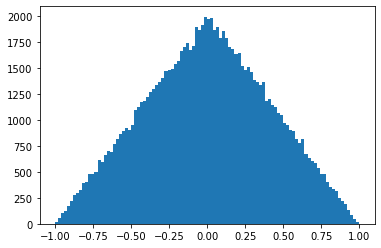

Time to compute the analytical function by hand: ~ 30 minutes
CPU times: user 253 ms, sys: 12 ms, total: 265 ms
Wall time: 262 ms


In [4]:
%%time
SZ = int(1e5)
def tinv(y):
    btm = np.sqrt(2*y) - 1
    top = 1 - np.sqrt(2 - 2*y)
    return btm * (y<0.5) + top * (y>=0.5)
y = np.random.uniform(0, 1, size=SZ)
x = tinv(y)
plt.hist(x, bins=100, range=[-1,1])
plt.show()
print("Time to compute the analytical function by hand: ~ 30 minutes")

We do the same with an exponential distribution
$$p(x) = e^{-x}\quad x\in[0,\infty)$$
the transformation function is the cumulant
$$t(x) = 1-e^{-x}$$
and its inverse can be easily computed
$$t^{-1}(y) = -\log(1-y)$$

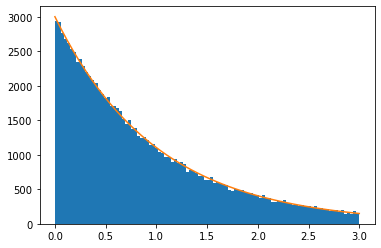

CPU times: user 241 ms, sys: 0 ns, total: 241 ms
Wall time: 238 ms


In [5]:
%%time
SZ = int(1e5)
def tinv(y):
    return -np.log(1 - y)
y = np.random.uniform(0, 1, size=SZ)
x = tinv(y)
plt.hist(x, bins=100, range=[0,3])

xe = np.linspace(0, 3)
plt.plot(xe, SZ*np.exp(-xe)*3/100, '-')

plt.show()

### Using the discrete transformation method
We take a Poisson distribution with mean 10
$$P(k)=\frac{10^k e^{-k}}{k!}$$
we compute the cumulant function $F(k)$ up to 30 and make a look-up table

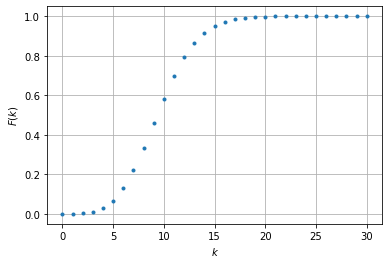

CPU times: user 196 ms, sys: 3.99 ms, total: 200 ms
Wall time: 197 ms


In [6]:
%%time
def P(k):
    return 10**k * np.exp(-10) / gamma(k+1)
lut_k, lut_F = [0], [P(0)]
for k in range(1, 31):
    lut_k.append(k)
    lut_F.append(lut_F[-1] + P(k))
plt.plot(lut_k, lut_F, ".")
plt.xlabel("$k$")
plt.ylabel("$F(k)$")
plt.grid()
plt.show()

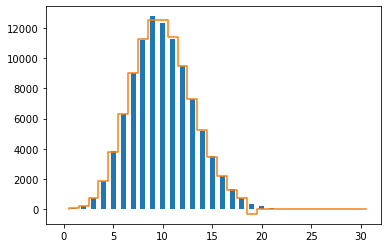

CPU times: user 163 ms, sys: 0 ns, total: 163 ms
Wall time: 164 ms


In [9]:
%%time
SZ = int(1e5)
r = np.random.uniform(0, 1, size=SZ)
comp = [(r > pF) & (r <= F) for F, pF in zip(lut_F, [0] + lut_F)]
x = sum(k * c for k, c in zip(lut_k, comp))
plt.hist(x, bins=31, range=[-0.5,30.5], rwidth=0.5)

xe = np.arange(31)
ye = P(xe)
plt.step(xe+0.5, SZ*ye)

plt.show()

We do the same with a binomial distribution with 30 trials and a success probability of each trial of 0.3
$$P(k) = \binom{30}{k}0.3^k0.7^{(30-k)}$$

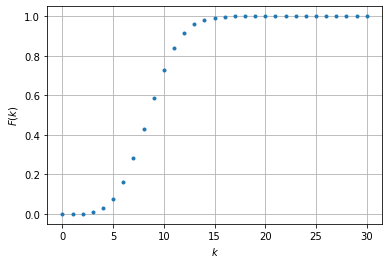

CPU times: user 134 ms, sys: 4.1 ms, total: 138 ms
Wall time: 136 ms


In [10]:
%%time
def P(k):
    return binom(30, k) * 0.3**k * 0.7**(30-k)
lut_k, lut_F = [0], [P(0)]
for k in range(1, 31):
    lut_k.append(k)
    lut_F.append(lut_F[-1] + P(k))
plt.plot(lut_k, lut_F, ".")
plt.xlabel("$k$")
plt.ylabel("$F(k)$")
plt.grid()
plt.show()

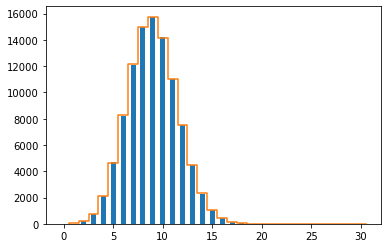

CPU times: user 174 ms, sys: 0 ns, total: 174 ms
Wall time: 174 ms


In [11]:
%%time
SZ = int(1e5)
r = np.random.uniform(0, 1, size=SZ)
comp = [(r > pF) & (r <= F) for F, pF in zip(lut_F, [0] + lut_F)]
x = sum(k * c for k, c in zip(lut_k, comp))
plt.hist(x, bins=31, range=[-0.5,30.5], rwidth=0.5)

xe = np.arange(31)
ye = P(xe)
plt.step(xe+0.5, SZ*ye)

plt.show()

### Using the convolution method
We generate a gaussian by summing uniform variables and exploiting the central limit theorem:
1. Generate 12 uniform random numbers in $[0,1]$ (they have $\sigma=1/\sqrt 12$)
2. Return the sum of the 12 numbers (the sum has $\sigma=1$) minus 6 (so the mean is zero

In [13]:
%%time
SZ = int(1e6)
u_samples = [np.random.uniform(size=SZ) for _ in range(12)]
g_samples = sum(u_samples, np.zeros_like(u_samples[0])) - 6

CPU times: user 142 ms, sys: 24.6 ms, total: 166 ms
Wall time: 165 ms


norm        2.387e+04 +- 29.6      
mu          0.0004738 +- 0.001018  
sigma           1.003 +- 0.0007543 
chi2/NDF        321.8 /  97        


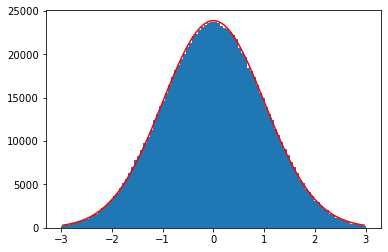

In [16]:
y, x, _ = plt.hist(g_samples, bins=100, range=[-3, 3])
x = (x[1:] + x[:-1]) / 2
sigma = np.sqrt(y)
def g(x, norm, mu, sigma):
    return norm * np.exp(-(x-mu)**2 / (2*sigma**2))
popt, pcov = curve_fit(g, x, y, p0=[24e3, 0, 1], sigma=sigma, absolute_sigma=True)
pstd = np.sqrt(pcov.diagonal())
for name, value, std in zip(["norm", "mu", "sigma"], popt, pstd):
    print(f"{name:10s} {value:10.4g} +- {std:<10.4g}")
chi2 = np.sum(((y - g(x, *popt)) / sigma)**2)
ndf = len(y) - len(popt)
print(f"chi2/NDF   {chi2:10.4g} /  {ndf:<10d}")
plt.plot(x, g(x, *popt), 'r-')
plt.show()

### Using the Metropolis-Hastings Markov-chain algorithm
We want to sample a Cauchy distribution (centered in 0 and with scale factor 1)
$$p(x)=\frac{1}{\pi}\frac{1}{1+x^2}$$
We need a symmetric PDF $q$ for the jumps: we take a uniform $U[-0.5,0.5]$.

In [17]:
%%cython --annotate
import cython
import numpy as np
cimport numpy as cnp

@cython.cdivision(True)
cdef double p(double x):
    return 1.0 / (1 + x**2)

@cython.boundscheck(False)
@cython.cdivision(True)
@cython.wraparound(False)
def cauchy(size: uint, start: double = 0.0, burnin: uint = 0):
    # Create the numpy arrays for input and output
    py_jumps: cnp.ndarray[cnp.double_t] = np.random.uniform(
        -0.5, 0.5, size+burnin-1)
    py_uniforms: cnp.ndarray[cnp.double_t] = np.random.uniform(
        0.0, 1.0, size+burnin-1)
    py_samples: cnp.ndarray[cnp.double_t] = np.empty(size+burnin)
    # Create memoryviews of the above arrays
    cdef cnp.ndarray[cnp.double_t, ndim=1, mode='c'] buf_jumps = (
        np.ascontiguousarray(py_jumps, np.double))
    cdef cnp.ndarray[cnp.double_t, ndim=1, mode='c'] buf_uniforms = (
        np.ascontiguousarray(py_uniforms, np.double))
    cdef cnp.ndarray[cnp.double_t, ndim=1, mode='c'] buf_samples = (
        np.ascontiguousarray(py_samples, np.double))
    # Use the memoryviews to access the data as double pointers
    cdef double* jumps = <double*>buf_jumps.data
    cdef double* uniforms = <double*>buf_uniforms.data
    cdef double* samples = <double*>buf_samples.data
    nx: double = 0.0
    samples[0] = start
    i: uint = 0
    for i in range(size+burnin-1):
        nx = samples[i] + jumps[i]
        if uniforms[i] <= p(nx) / p(samples[i]):
            samples[i+1] = nx
        else:
            samples[i+1] = samples[i]
    return py_samples[burnin:]

In [20]:
%%time
SZ = int(1e4)
wo_burnin = cauchy(SZ, -5)
w_burnin = cauchy(SZ, -5, SZ)

CPU times: user 4.91 ms, sys: 51 µs, total: 4.96 ms
Wall time: 3.86 ms


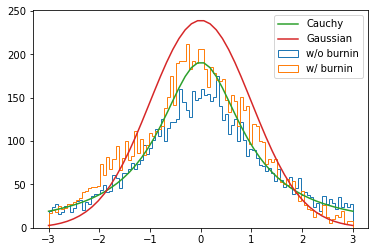

In [21]:
plt.hist(wo_burnin, bins=100, range=[-3,3], histtype='step', label="w/o burnin")
plt.hist(w_burnin, bins=100, range=[-3,3], histtype='step', label="w/ burnin")
xe = np.linspace(-3, 3)
plt.plot(xe, SZ / np.pi / (1 + xe**2) * 6/100, '-', label="Cauchy")
plt.plot(xe, SZ / np.sqrt(2*np.pi) * np.exp(-0.5 * xe**2) * 6/100, '-', label="Gaussian")
plt.legend()
plt.show()

## Compute the 13-dimensional hypersphere volume
We take a 13-dimensional hypercube with side 2 centered in the origin, which completely encloses the hypersphere of radius 1 centered in the origin, and has volume $V_C = 2^{13}=8192$.
We then take a uniform random sampling of the cube volume, and count the points within the sphere.
The volume of the sphere is given by
$$V_S=V_C\frac{N_\text{points in the sphere}}{N_\text{total points}}$$

In [22]:
%%time
SZ = int(1e7)
VC = 2**13
x = [np.random.uniform(-1, 1, size=SZ) for _ in range(13)]
r2 = sum(i**2 for i in x)
vs = np.count_nonzero(r2 < 1) / len(r2) * VC
print(f"VS = {vs:.3g}")

VS = 0.943
CPU times: user 1.74 s, sys: 224 ms, total: 1.96 s
Wall time: 1.97 s


The analytical formula for the volume is
$$V_S=\frac{\pi^{13/2}}{\Gamma(13/2+1)}$$

In [23]:
VSA = np.pi**(13/2) / gamma(13/2+1)
VSA

0.9106287547832829

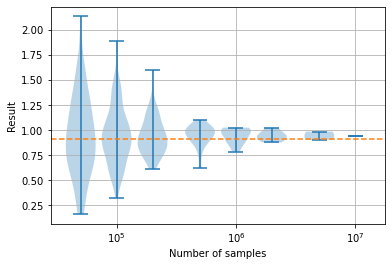

In [49]:
n = np.array([5e4, 1e5, 2e5, 5e5, 1e6, 2e6, 5e6, 1e7], dtype=int)
vs = [np.array([np.count_nonzero(r2[j*i:(j+1)*i] < 1) / i * VC
       for j in range(len(r2)//i)]) for i in n]
l = np.log10(n)
# n = [[i] * (len(r2)//i) for i in n]
# n = np.fromiter((x for y in n for x in y), float)
# vs = np.fromiter((x for y in vs for x in y), float)
# plt.semilogx(n, vs, '.')
plt.violinplot(vs, l, widths=0.25)
xl, xu = plt.xlim()
plt.plot([xl, xu], [VSA, VSA], '--')
plt.xlim(xl, xu)
plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1.0))
plt.gca().xaxis.set_major_formatter(ticker.FormatStrFormatter(
    "$10^{%d}$"))
plt.grid()
plt.xlabel("Number of samples")
plt.ylabel("Result")
plt.show()